This notebook is going to look at the mistakes made by the chosen model. Specifically, it's going to look at the log loss for each class on the validation set and produce a Hinton diagram for all the classes to show the confusion matrix for this model. Then, it will find the class performing worst and plot example images from this class _after processing_.

Aiming for it to be written in such a way that the model file chosen can just be swapped in, so we can try it on different models.

Setup and prediction
=======

Doing the exact same thing as in the notebook on Holdout set testing, creating a set of predictions:

In [1]:
# copying imports from holdout notebook...
import pylearn2.utils
import pylearn2.config
import theano
import neukrill_net.dense_dataset
import neukrill_net.utils
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import holoviews as hl
%load_ext holoviews.ipython
import sklearn.metrics

Using gpu device 0: Tesla K40c
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Welcome to the HoloViews IPython extension! (http://ioam.github.io/holoviews/)
Available magics: %compositor, %opts, %params, %view, %%labels, %%opts, %%view


In [2]:
cd ..

/afs/inf.ed.ac.uk/user/s08/s0805516/repos/neukrill-net-work


In [3]:
settings = neukrill_net.utils.Settings("settings.json")
run_settings = neukrill_net.utils.load_run_settings(
    "run_settings/alexnet_based_norm_global_8aug.json", settings, force=True)

In [4]:
# loading the model
model = pylearn2.utils.serial.load(run_settings['pickle abspath'])

In [5]:
# loading the data
dataset = neukrill_net.dense_dataset.DensePNGDataset(settings_path=run_settings['settings_path'],
                                            run_settings=run_settings['run_settings_path'],
                                                     train_or_predict='train',
                                                     training_set_mode='validation', force=True)

In [6]:
batch_size=500
while dataset.X.shape[0]%batch_size != 0:
    batch_size += 1
n_batches = int(dataset.X.shape[0]/batch_size)
# set this batch size
model.set_batch_size(batch_size)
# compile Theano function
X = model.get_input_space().make_batch_theano()
Y = model.fprop(X)
f = theano.function([X],Y)

In [7]:
%%time
y = np.zeros((dataset.X.shape[0],len(settings.classes)))
for i in xrange(n_batches):
    print("Batch {0} of {1}".format(i+1,n_batches))
    x_arg = dataset.X[i*batch_size:(i+1)*batch_size,:]
    if X.ndim > 2:
        x_arg = dataset.get_topological_view(x_arg)
    y[i*batch_size:(i+1)*batch_size,:] = (f(x_arg.astype(X.dtype).T))

Batch 1 of 34
Batch 2 of 34
Batch 3 of 34
Batch 4 of 34
Batch 5 of 34
Batch 6 of 34
Batch 7 of 34
Batch 8 of 34
Batch 9 of 34
Batch 10 of 34
Batch 11 of 34
Batch 12 of 34
Batch 13 of 34
Batch 14 of 34
Batch 15 of 34
Batch 16 of 34
Batch 17 of 34
Batch 18 of 34
Batch 19 of 34
Batch 20 of 34
Batch 21 of 34
Batch 22 of 34
Batch 23 of 34
Batch 24 of 34
Batch 25 of 34
Batch 26 of 34
Batch 27 of 34
Batch 28 of 34
Batch 29 of 34
Batch 30 of 34
Batch 31 of 34
Batch 32 of 34
Batch 33 of 34
Batch 34 of 34
CPU times: user 4.61 s, sys: 11.9 s, total: 16.5 s
Wall time: 16.6 s


In [8]:
af = run_settings.get("augmentation_factor",1)
if af > 1:
    y_collapsed = np.zeros((int(dataset.X.shape[0]/af), len(settings.classes))) 
    for i,(low,high) in enumerate(zip(range(0,dataset.y.shape[0],af),
                                      range(af,dataset.y.shape[0]+af,af))):
        y_collapsed[i,:] = np.mean(y[low:high,:], axis=0)
    y = y_collapsed
    labels = dataset.y[range(0,dataset.y.shape[0],af)]
else:
    labels = dataset.y

Log loss by class
======

Creating a bar chart of log loss by class:

In [9]:
import sklearn.metrics

In [10]:
# split predictions by class and calculate log loss
results = {}
uniform = {}
for c in range(121):
    class_mask = labels.ravel() == c
    l = np.zeros(y.shape[0])
    l[np.where(class_mask)] = 1
    p = np.zeros((y.shape[0],2))
    p[:,1] = sum(class_mask)/len(class_mask)
    p[:,0] = 1-p[:,1]
    uniform[c] = sklearn.metrics.log_loss(l,p)
    p[:,1] = y[:,c]
    p[:,0] = 1-p[:,1]
    results[c] = sklearn.metrics.log_loss(l,p)

Comparing the score of the network against a uniform benchmark on a scatter plot:

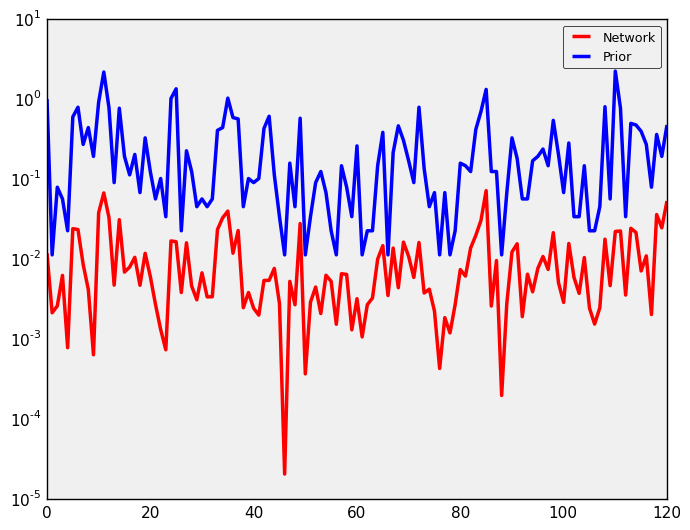

In [11]:
plt.plot(range(121),[results[c] for c in range(121)], c="red", label="Network")
plt.plot(range(121),[uniform[c] for c in range(121)], c="blue", label="Prior")
plt.yscale("log")
l=plt.legend()

May be better to take the improvement on uniform as a score:

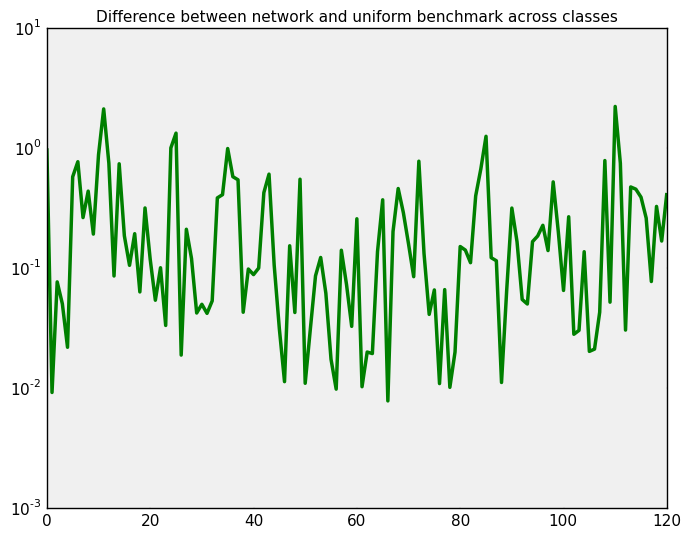

In [12]:
differences = np.array([uniform[c]-results[c] for c in range(121)])
plt.plot(range(121),differences, c="green")
plt.title("Difference between network and uniform benchmark across classes")
plt.yscale("log")

Finding out which is the worst:

In [151]:
worst = np.where(differences == max(differences))[0][0]
print("Worst performance on: {0}".format(settings.classes[worst]))

Worst performance on: trichodesmium_puff


What's it being confused with?

In [164]:
inds = []
confdict = {}
for i,w in enumerate(labels == worst):
    if w:
        r = y[i,:]
        predicted = np.where(r == max(r))[0]
        if predicted != worst:
            inds.append(i)
            print("{0} confused with: {1}".format(settings.classes[worst],
                                                  settings.classes[predicted]))
            confdict[i] = str(settings.classes[predicted][0].upper()
                              +settings.classes[predicted][1:])
inds = np.array(inds)

trichodesmium_puff confused with: trichodesmium_tuft
trichodesmium_puff confused with: trichodesmium_bowtie
trichodesmium_puff confused with: trichodesmium_bowtie
trichodesmium_puff confused with: trichodesmium_bowtie
trichodesmium_puff confused with: trichodesmium_bowtie
trichodesmium_puff confused with: echinoderm_larva_seastar_brachiolaria
trichodesmium_puff confused with: detritus_blob


In [165]:
inds

array([2586, 2614, 2641, 2657, 2686, 2688, 2707])

In [166]:
example_images = dataset.get_topological_view(dataset.X[inds*8,:]).reshape(-1,48,48)

In [167]:
confdict

{2586: 'Trichodesmium_tuft',
 2614: 'Trichodesmium_bowtie',
 2641: 'Trichodesmium_bowtie',
 2657: 'Trichodesmium_bowtie',
 2686: 'Trichodesmium_bowtie',
 2688: 'Echinoderm_larva_seastar_brachiolaria',
 2707: 'Detritus_blob'}

These are all trichodesmium_puffs, labels indicate what they were confused with.


Image
      Trichodesmium_tuft                    : Image.Image.Trichodesmium_tuft                      (z)
      Trichodesmium_bowtie                 
         I  : Image.Image.Trichodesmium_bowtie   (z)
         II : Image.Image.Trichodesmium_bowtie   (z)
      Echinoderm_larva_seastar_brachiolaria : Image.Image.Echinoderm_larva_seastar_brachiolaria   (z)
      Detritus_blob                         : Image.Image.Detritus_blob                           (z)
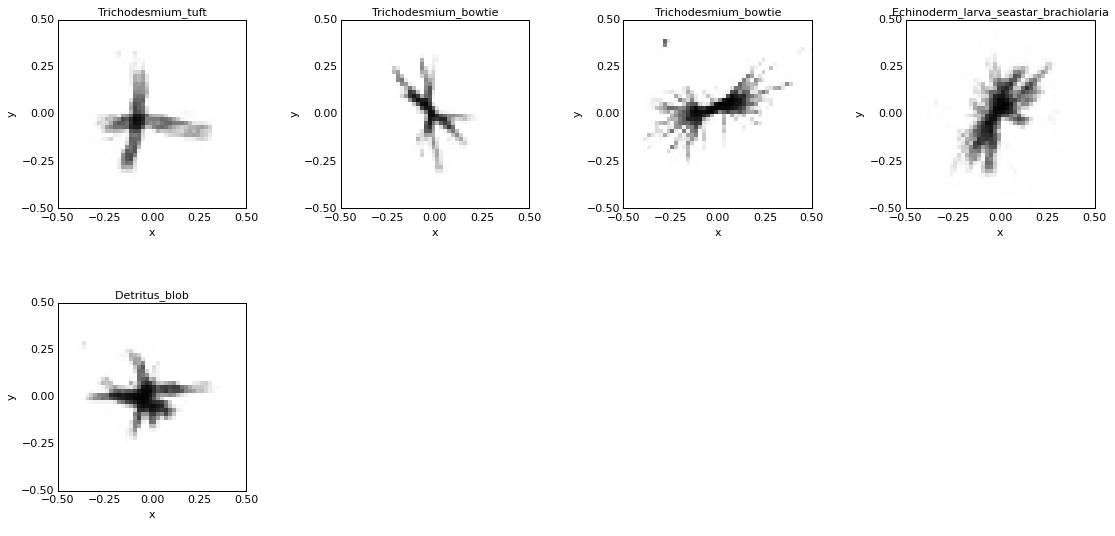

In [170]:
%opts Image style(cmap='gray')
channels = hl.Image(example_images[0,:,:],label=confdict[inds[0]])
for i,j in enumerate(inds[1:]):
    channels = channels + hl.Image(example_images[i],label=confdict[j])
print("These are all trichodesmium_puffs, labels indicate what they were confused with.")
channels

In [132]:
confusion = []
for r in y[inds,:]:
    predicted = np.where(r == max(r))[0][0]
    confusion.append(predicted)

Image
      Detritus_blob                        
         I  : Image.Image.Detritus_blob   (z)
         II : Image.Image.Detritus_blob   (z)
      Echinoderm_larva_seastar_brachiolaria
         I  : Image.Image.Echinoderm_larva_seastar_brachiolaria   (z)
         II : Image.Image.Echinoderm_larva_seastar_brachiolaria   (z)
      Trichodesmium_bowtie                 
         I  : Image.Image.Trichodesmium_bowtie   (z)
         II : Image.Image.Trichodesmium_bowtie   (z)
      Trichodesmium_tuft                   
         I  : Image.Image.Trichodesmium_tuft   (z)
         II : Image.Image.Trichodesmium_tuft   (z)
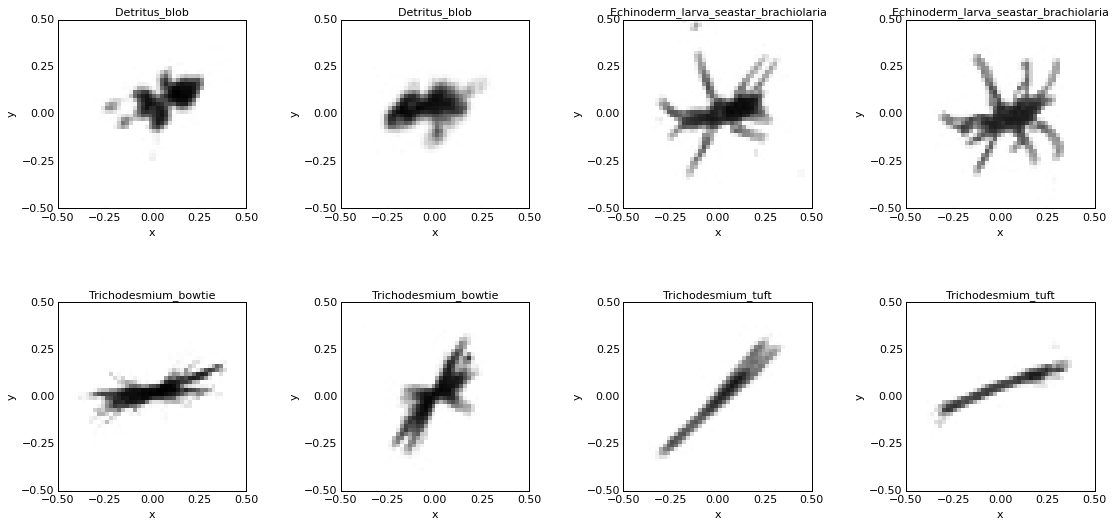

In [133]:
channels = None
for c in list(set(confusion)):
    np.random.seed(42)
    cinds = np.where(labels == c)[0]
    cinds.setflags(write=True)
    np.random.shuffle(cinds)
    cinds = cinds[:4]
    c_examples = dataset.get_topological_view(
                        dataset.X[cinds*8,:]).reshape(4,48,48)
    cs = str(settings.classes[c])
    cs = cs[:1].upper() + cs[1:]
    for i in range(4):
        if not channels:
            channels = hl.Image(c_examples[i,:,:], label=cs)
        else:
            channels = channels + hl.Image(c_examples[i,:,:], label=cs)
channels

Worst Datapoints
======

Now it's probably worth plotting whcih datapoints the network is gettings confused about most, when it's getting confused. So, we find the datapoints with the highest log loss.

In [178]:
N = y.shape[0]

In [179]:
logloss = lambda x: -(1./N)*np.log(x[0][x[1]])[0]

Checking I've written this right:

In [180]:
sum(map(logloss,zip(y,labels)))

0.83652759297870927

In [181]:
sklearn.metrics.log_loss(labels,y)

0.83652760102200086

Now we can iterate over all the datapoints and find the worst:

In [182]:
ll = []
for i,(p,l) in enumerate(zip(y,labels)):
    ll.append((i,logloss((p,l))))

In [183]:
ll.sort(key=lambda x: x[-1])

In [184]:
# interesting index to happen
worst = ll[-1][0]
ll[-1]

(1984, 0.0065892197236871435)

Now, we want to plot this index along with examples of what it's being confused with. First, find the class it's being confused with and get some indices for that:

In [185]:
real = dataset.get_topological_view(dataset.X[worst*8:(worst*8)+1,:]).squeeze()
realname = settings.classes[labels[worst][0]]
# capitalise for holoviews...
realname = str(realname[0].upper() + realname[1:])

In [186]:
confused = np.where(y[worst] == max(y[worst]))[0][0]

In [187]:
np.where(labels == confused)[0]

array([2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396,
       2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407,
       2408, 2409, 2410])

In [188]:
settings.classes[confused]

u'siphonophore_calycophoran_sphaeronectes_young'

In [189]:
cexamples = dataset.get_topological_view(dataset.X[np.where(labels == confused)[0]*8,:]).squeeze()

Protist_fuzzy_olive                          
      I : Image.Protist_fuzzy_olive   (z)
   Siphonophore_calycophoran_sphaeronectes_young
      I     : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      II    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      III   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      IV    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      V     : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      VI    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      VII   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      VIII  : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      IX    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      X     : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XI    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XII   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XIII  : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XIV   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XV    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XVI   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XVII  : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XVIII : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XIX   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XX    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XXI   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XXII  : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XXIII : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XXIV  : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XXV   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
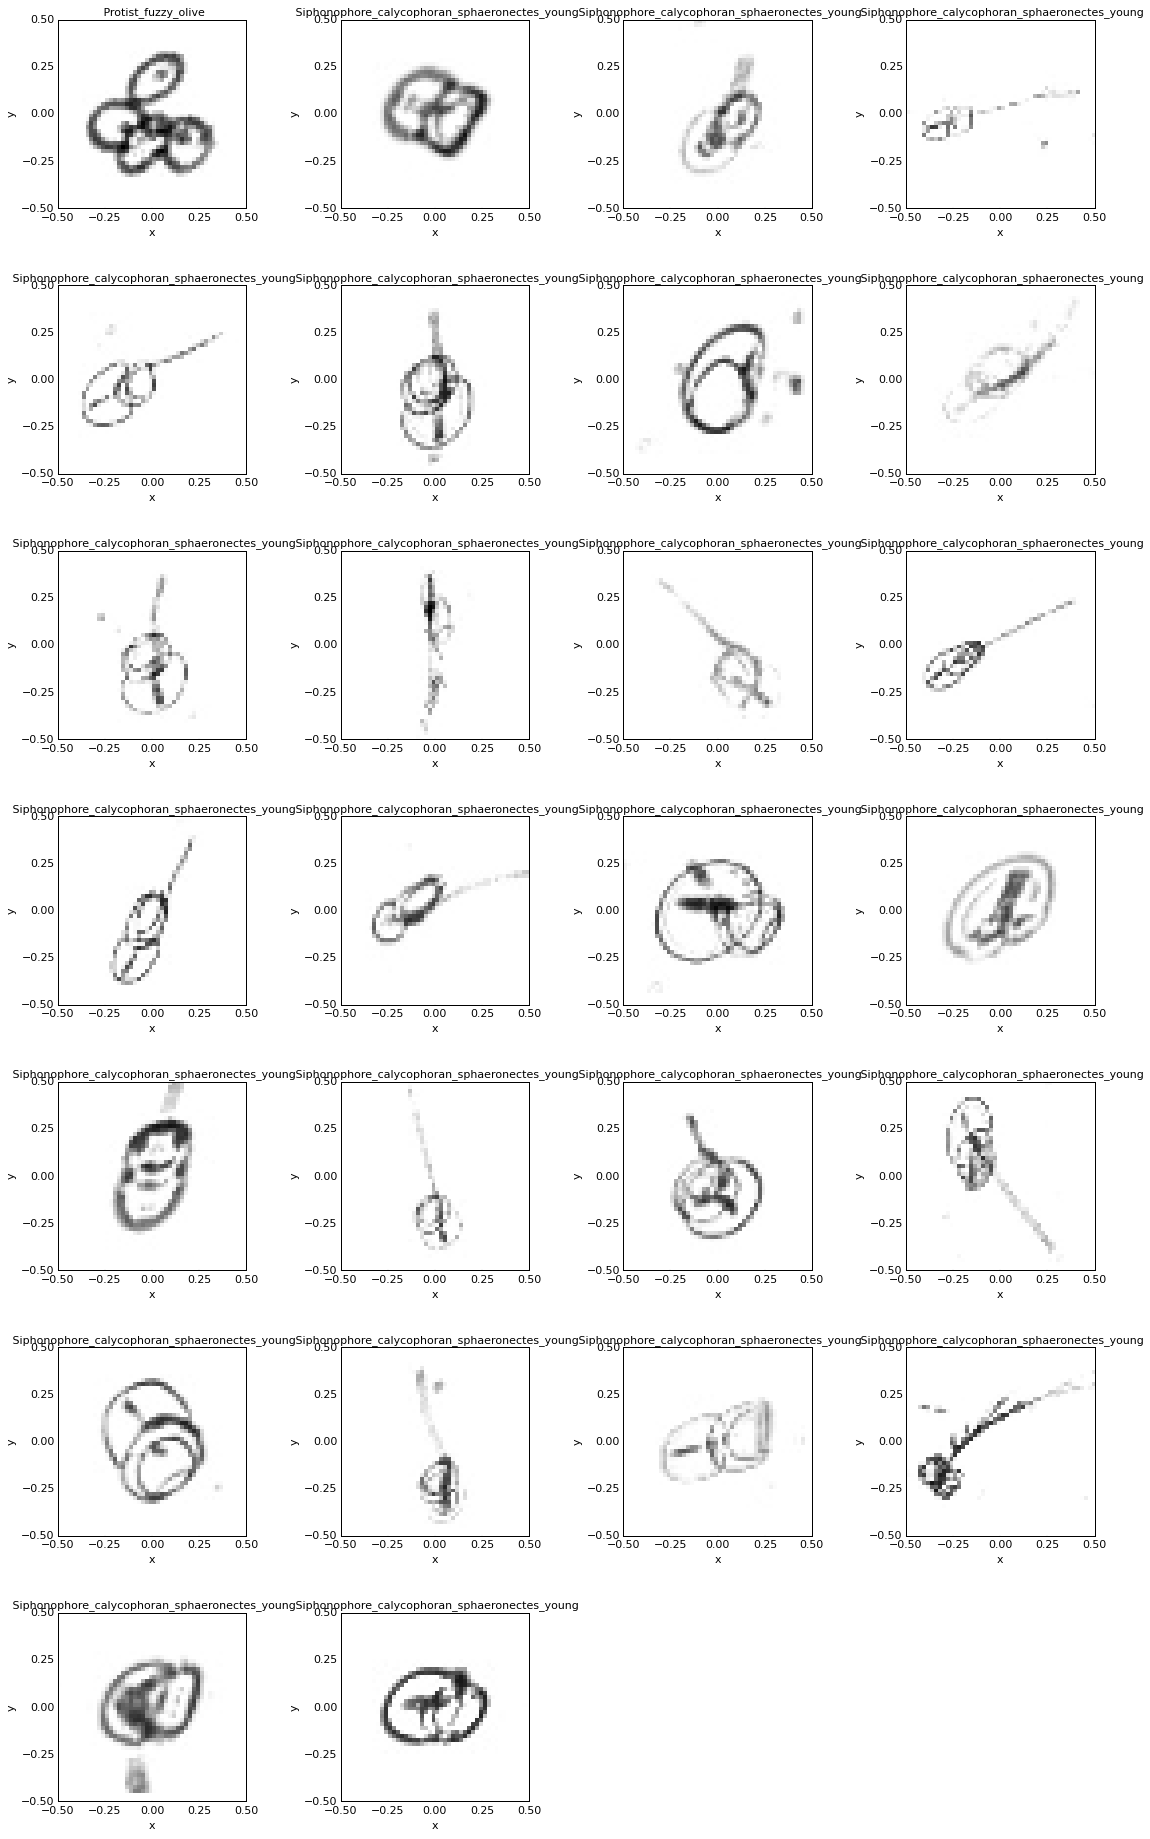

In [190]:
channels = hl.Image(real,group=realname)
for c in cexamples:
    cs = str(settings.classes[confused])
    cs = cs[:1].upper() + cs[1:]
    channels += hl.Image(c, group=cs)
channels

I guess the question is, how is the network supposed to be able to tell the difference in this case? More resolution?

Plotting the above with raw images:

In [191]:
rawX,_ = neukrill_net.utils.load_rawdata(dataset.settings.image_fnames,classes=settings.classes)

In [192]:
cexamples = [rawX[i] for i in np.where(labels == confused)[0]]
real = rawX[worst]

Protist_fuzzy_olive                          
      I : Image.Protist_fuzzy_olive   (z)
   Siphonophore_calycophoran_sphaeronectes_young
      I     : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      II    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      III   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      IV    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      V     : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      VI    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      VII   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      VIII  : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      IX    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      X     : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XI    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XII   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XIII  : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XIV   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XV    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XVI   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XVII  : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XVIII : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XIX   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XX    : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XXI   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XXII  : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XXIII : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XXIV  : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
      XXV   : Image.Siphonophore_calycophoran_sphaeronectes_young   (z)
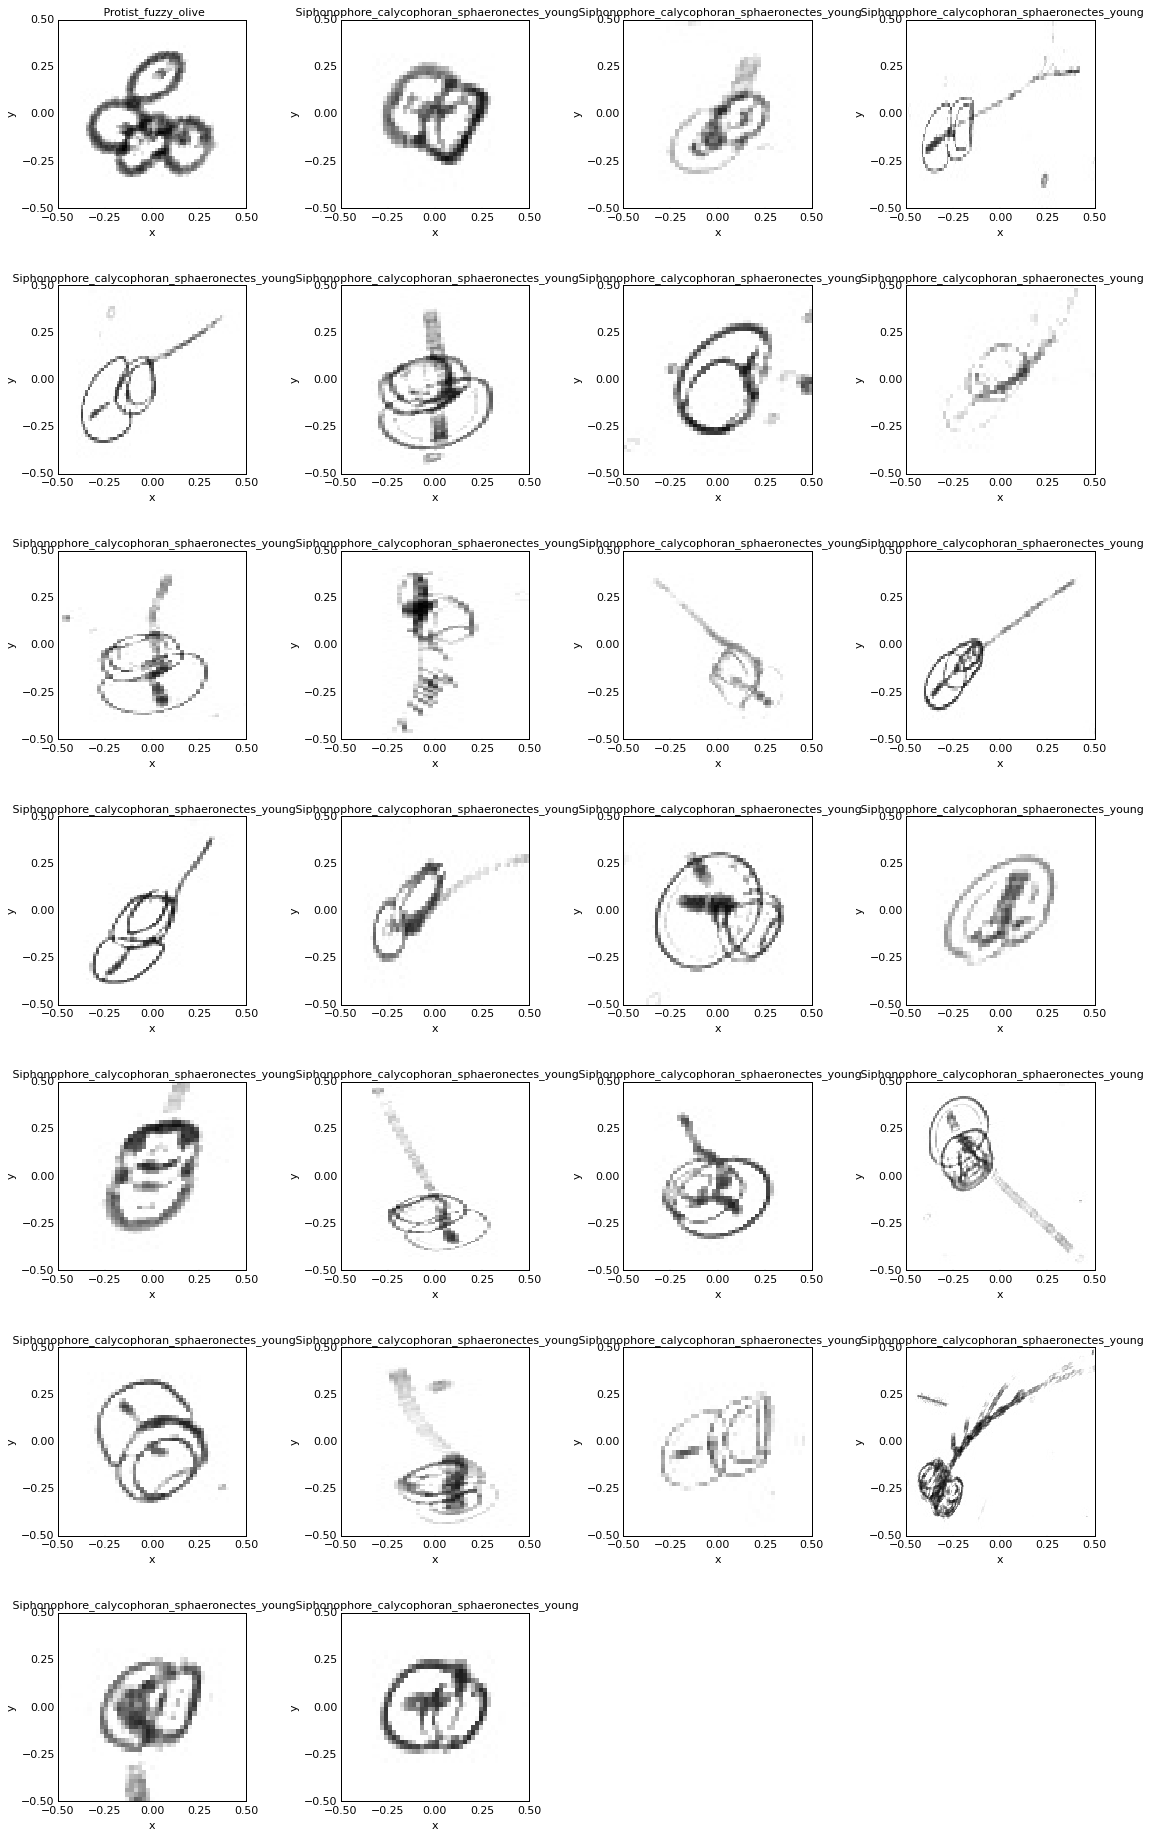

In [193]:
channels = hl.Image(real,group=realname)
for c in cexamples:
    cs = str(settings.classes[confused])
    cs = cs[:1].upper() + cs[1:]
    channels += hl.Image(c, group=cs)
channels

Yeah, looks like our resizing is losing some of the fine-grained detail. Although, that protist fuzzy olive that was the worst has changed relatively little; it was already fuzzy.

Confusion Matrix
======

We'd like to plot a confusion matrix for these predictions. To do this, we're going to want to use a Hinton plot, because otherwise it's going to be difficult to interpret the 121 by 121 matrix by eye. First, Scikit-learn will make the confusion matrix array for us:

In [196]:
# have to discretize y... not comfortable with this
discy = []
for p in y:
    discy.append(np.where(p == max(p))[0][0])
discy = np.array(discy)

In [207]:
discy

array([86,  0,  0, ..., 72, 85, 85])

In [213]:
labels.ravel()

array([  0,   0,   0, ..., 120, 120, 120])

In [214]:
confmat = sklearn.metrics.confusion_matrix(labels.ravel(),discy)

In [215]:
confmat

array([[84,  2,  1, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  0],
       [ 1,  0,  4, ...,  0,  0,  0],
       ..., 
       [ 0,  0,  0, ...,  5,  0,  0],
       [ 0,  0,  0, ...,  0,  2,  0],
       [ 0,  0,  0, ...,  0,  0,  4]])

In [219]:
import neukrill_net.hinton_diagram

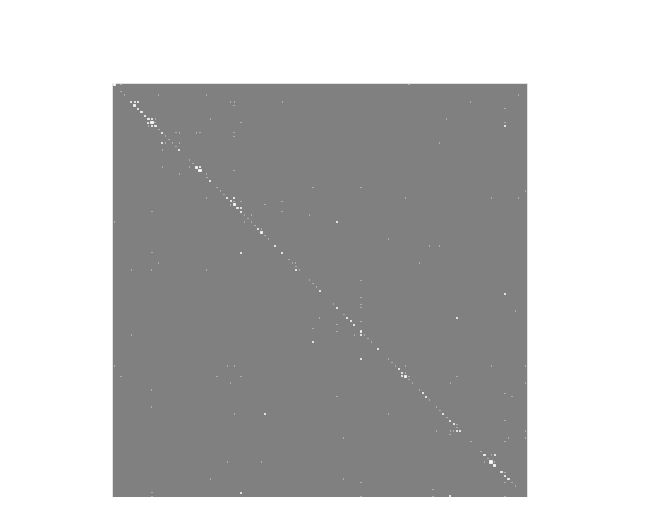

In [221]:
neukrill_net.hinton_diagram.hinton(confmat)

Where are the big false positives? We can make a new array just including those, in a configuration we know?

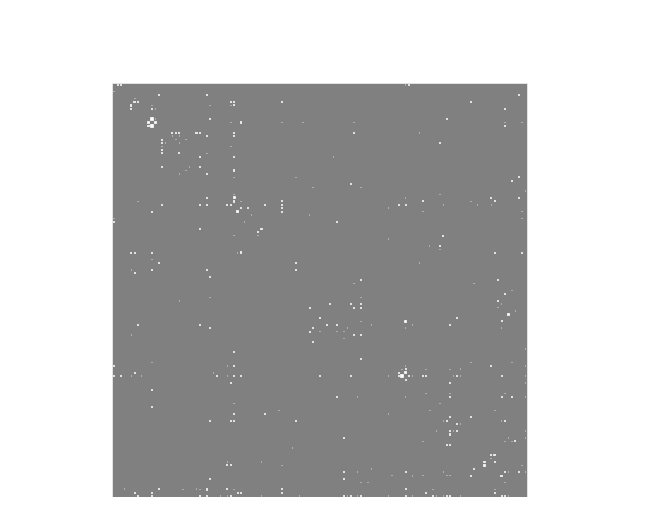

In [228]:
# removing diagonal elements:
diags = np.where(np.eye(len(settings.classes)) == 1)
ndconfmat = confmat
ndconfmat[diags[0],diags[1]] = 0
neukrill_net.hinton_diagram.hinton(ndconfmat)

In [231]:
# which elements are the biggest?
for m in np.sort(ndconfmat.ravel())[-10:]:
    print("{0} at {1}".format(m,np.where(ndconfmat==m)))

7 at (array([  5, 108, 120]), array([  6, 111,  98]))
7 at (array([  5, 108, 120]), array([  6, 111,  98]))
9 at (array([49]), array([37]))
10 at (array([84]), array([85]))
11 at (array([33]), array([35]))
16 at (array([10]), array([11]))
17 at (array([11, 12]), array([12, 11]))
17 at (array([11, 12]), array([12, 11]))
19 at (array([85]), array([84]))
21 at (array([11]), array([10]))


So confusion is greatest between classes 10 and 11? We could plot examples of those two classes:

In [250]:
c10inds = np.where(labels==10)[0]
c11inds = np.where(labels==11)[0]
c10name = str(settings.classes[10][0].upper()+settings.classes[10][1:])
c11name = str(settings.classes[11][0].upper()+settings.classes[11][1:])

Image                  
      Chaetognath_non_sagitta : Image.Image.Chaetognath_non_sagitta   (z)
   Chaetognath_non_sagitta
      I    : Image.Chaetognath_non_sagitta   (z)
      II   : Image.Chaetognath_non_sagitta   (z)
      III  : Image.Chaetognath_non_sagitta   (z)
      IV   : Image.Chaetognath_non_sagitta   (z)
      V    : Image.Chaetognath_non_sagitta   (z)
      VI   : Image.Chaetognath_non_sagitta   (z)
      VII  : Image.Chaetognath_non_sagitta   (z)
      VIII : Image.Chaetognath_non_sagitta   (z)
      IX   : Image.Chaetognath_non_sagitta   (z)
      X    : Image.Chaetognath_non_sagitta   (z)
   Chaetognath_other      
      I    : Image.Chaetognath_other   (z)
      II   : Image.Chaetognath_other   (z)
      III  : Image.Chaetognath_other   (z)
      IV   : Image.Chaetognath_other   (z)
      V    : Image.Chaetognath_other   (z)
      VI   : Image.Chaetognath_other   (z)
      VII  : Image.Chaetognath_other   (z)
      VIII : Image.Chaetognath_other   (z)
      IX   : Image.Chaetognath_other   (z)
      X    : Image.Chaetognath_other   (z)
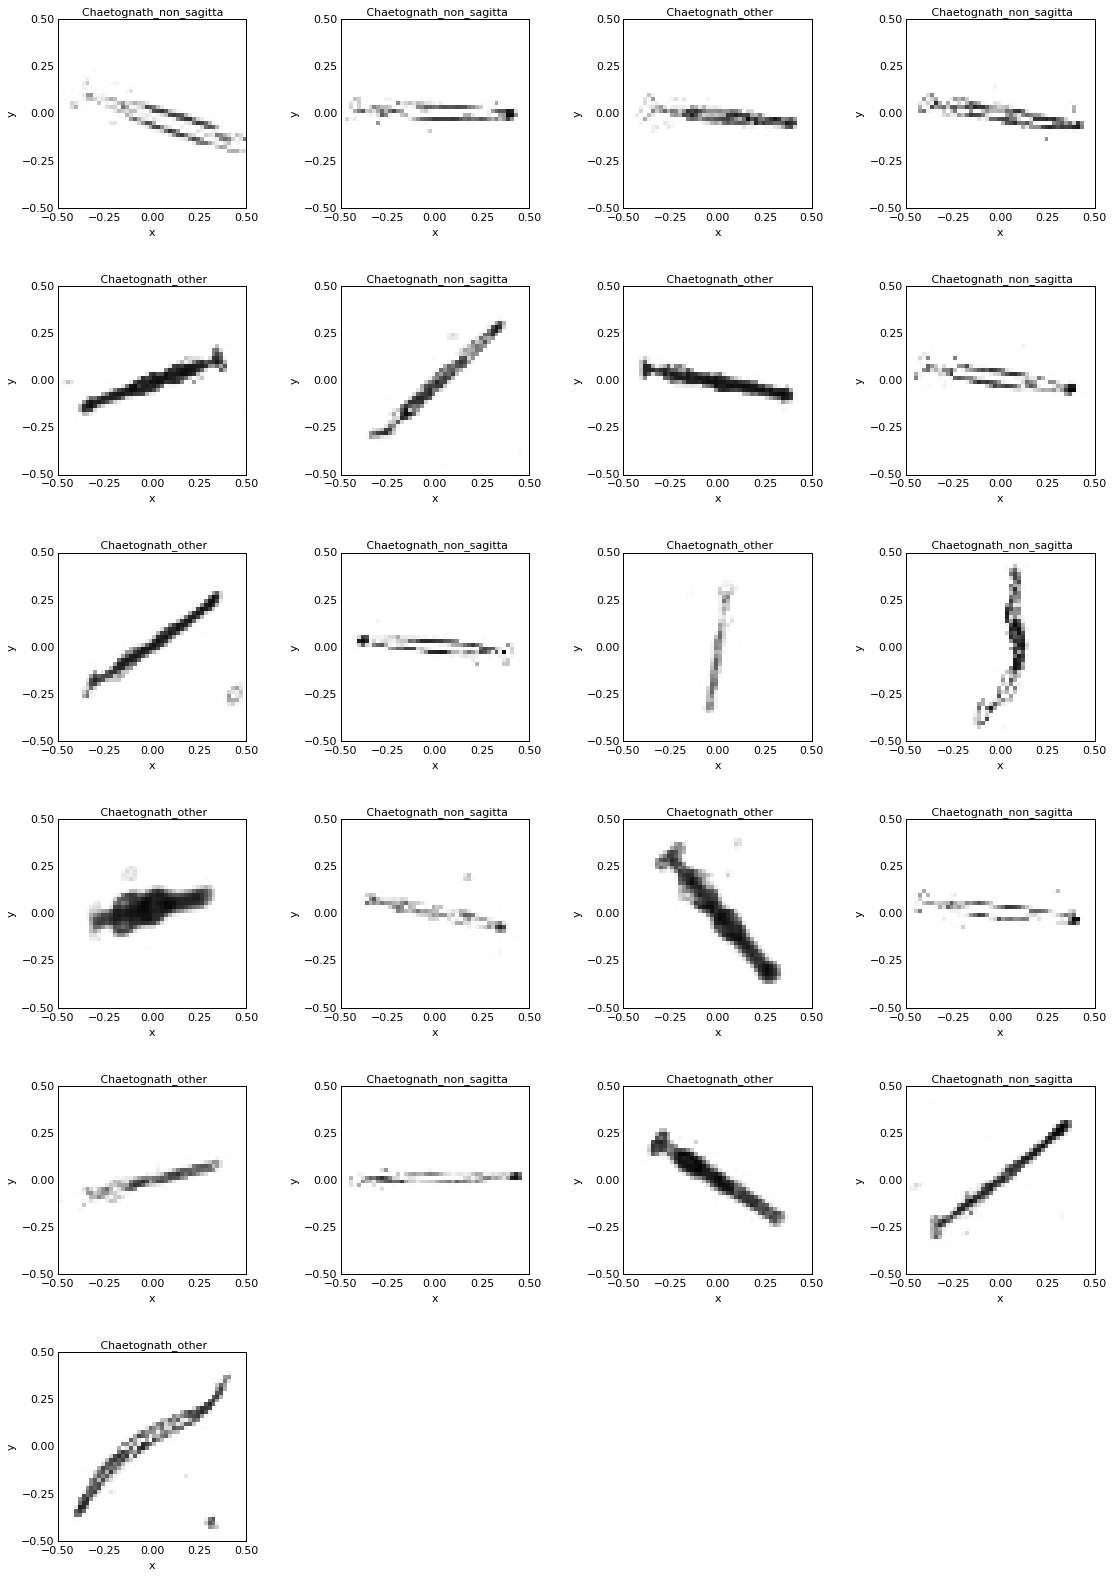

In [252]:
example = dataset.get_topological_view(
    dataset.X[c10inds[-2]*8:(c10inds[-2]*8)+1,:]).squeeze()
channels = hl.Image(example, label=c10name)
for i,j in zip(c10inds[:10],c11inds[:10]):
    # because I want them interleaved
    for k in ((i, c10name),(j, c11name)):
        example = dataset.get_topological_view(
            dataset.X[k[0]*8:(k[0]*8)+1,:]).squeeze()
        channels += hl.Image(example, group=k[1])
channels